#### **1. Import Libraries**

In [1]:
from keybert import KeyBERT
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import string
import numpy as np
import spacy

# Load spacy model for lemmatization
nlp = spacy.load("en_core_web_sm")

#### **2. Define File-Year Mappings and Load Data**

In [2]:
# Define the files and their associated years
file_year_mapping = {
    "papers-semeval-2021.json": 2021,
    "papers-semeval-2022.json": 2022,
    "papers-semeval-2023.json": 2023,
    "papers-semeval-2024.json": 2024,
}

# Load abstracts by year
abstracts_by_year = defaultdict(list)
for file, year in file_year_mapping.items():
    with open(file, "r", encoding="utf-8") as f:
        papers = json.load(f)
        abstracts = [paper["abstract"] for paper in papers if paper.get("abstract")]
        abstracts_by_year[year] = abstracts

#### **3. Preprocess Text (Lemmatization)**

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized

#### **4. Extract Keyphrases Using TF-IDF**

In [4]:
def extract_keyphrases_tfidf(abstracts):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(abstracts)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate mean TF-IDF score for each term
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    term_scores = [(feature_names[i], tfidf_scores[i]) for i in range(len(feature_names))]
    term_scores = sorted(term_scores, key=lambda x: x[1], reverse=True)

    return term_scores

#### **5. Extract Keyphrases Using KeyBERT**

In [5]:
kw_model = KeyBERT()

# Extract keyphrases using KeyBERT
def extract_keyphrases_keybert(abstracts, top_n=5):
    all_phrases = []
    for abstract in abstracts:
        keyphrases = kw_model.extract_keywords(abstract, keyphrase_ngram_range=(1, 3), top_n=top_n)
        all_phrases.extend(keyphrases)  # Keyphrases is a list of (phrase, score)
    return all_phrases

#### **6. Process Keyphrases Per Year**

In [6]:
keyphrases_by_year = {}
all_keyphrases = defaultdict(list)
for year, abstracts in abstracts_by_year.items():
    processed_abstracts = [preprocess_text(abstract) for abstract in abstracts]
    keyphrase_scores = extract_keyphrases_keybert(processed_abstracts)
    keyphrase_scores = [(term, score) for term, score in keyphrase_scores if len(term.split()) >= 2]
    keyphrases_by_year[year] = keyphrase_scores
    for term, score in keyphrase_scores:
        all_keyphrases[term].append((year, score))
    print(f"Year {year}: {len(keyphrase_scores)} keyphrases extracted")

Year 2021: 928 keyphrases extracted
Year 2022: 1157 keyphrases extracted
Year 2023: 1582 keyphrases extracted
Year 2024: 1386 keyphrases extracted


#### **7. Embed Keyphrases Using Sentence-BERT**

In [7]:
def embed_keyphrases(keyphrases):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode([term for term, _ in keyphrases])
    return embeddings

#### **8. Cluster Keyphrases**

In [8]:
def cluster_keyphrases(embeddings, keyphrases, n_clusters=50):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    clustered_keyphrases = defaultdict(list)
    for label, (term, score) in zip(labels, keyphrases):
        clustered_keyphrases[label].append((term, score))

    return clustered_keyphrases

#### **9. Analyze Clustered Trends**

In [9]:
def analyze_clustered_trends(clustered_keyphrases, all_keyphrases):
    trends = {}
    for cluster, phrases in clustered_keyphrases.items():
        cluster_scores = defaultdict(list)
        for term, _ in phrases:
            if term in all_keyphrases:
                for year, score in all_keyphrases[term]:
                    cluster_scores[year].append(score)

        aggregated_scores = {year: np.mean(scores) for year, scores in cluster_scores.items()}
        trends[cluster] = aggregated_scores

    return trends

#### **10. Identify Top Risers and Fallers**

In [34]:
def identify_risers_and_fallers(clustered_trends, clustered_keyphrases, top_n=20):
    trend_changes = []
    for cluster, trends in clustered_trends.items():
        years = sorted(trends.keys())
        if len(years) > 1:
            change = trends[years[-1]] - trends[years[0]]
            trend_changes.append((cluster, change))

    risers = sorted(trend_changes, key=lambda x: x[1], reverse=True)[:top_n]
    fallers = sorted(trend_changes, key=lambda x: x[1])[:top_n]

    def get_representative_terms(cluster):
        terms = [term for term, _ in clustered_keyphrases[cluster]]
        return ", ".join(terms[:3])

    return [(cluster, change, get_representative_terms(cluster)) for cluster, change in risers], \
           [(cluster, change, get_representative_terms(cluster)) for cluster, change in fallers]

#### **11. Plot Results**

In [75]:
def plot_cluster_trends(clusters, clustered_trends, title):
    plt.figure(figsize=(16, 10))
    for cluster, _, representative_terms in clusters:
        trends = clustered_trends[cluster]
        years = sorted(trends.keys())
        scores = [trends[year] for year in years]
        plt.plot(years, scores, marker='o', label=f"Topic {cluster}: {representative_terms}")
        for year, score in zip(years, scores):
            plt.text(year, score, str(cluster), fontsize=8, ha='right')

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Mean TF-IDF Score")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid()
    plt.tight_layout()
    plt.show()

#### **12. Finding the optimal number of clusters**

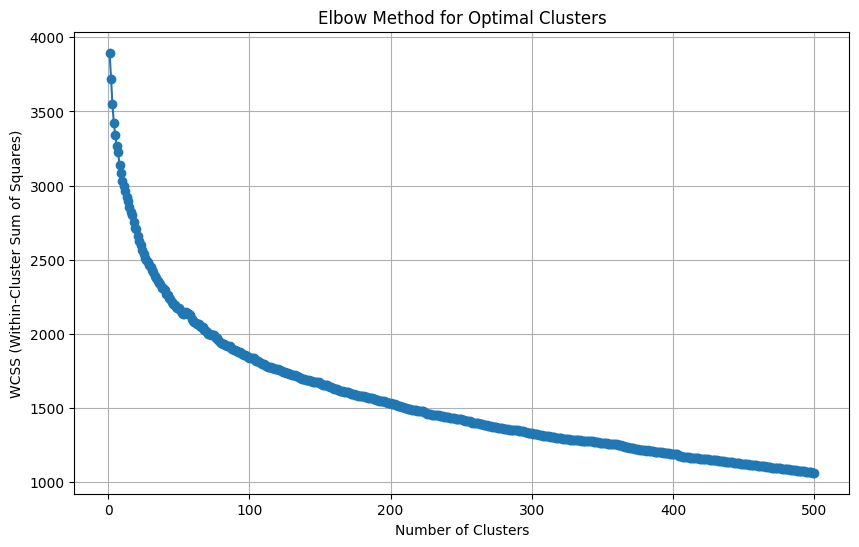

In [27]:
# Find the optimal number of clusters using the Elbow Method
def determine_optimal_clusters(embeddings, max_clusters=500):
    wcss = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)  # Within-cluster sum of squares

    # Plot the Elbow Method results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title("Elbow Method for Optimal Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.grid()
    plt.show()

# Execute the Elbow Method
all_keyphrase_list = [(term, score) for term, scores in all_keyphrases.items() for year, score in scores]
embeddings = embed_keyphrases([(term, score) for term, score in all_keyphrase_list])
determine_optimal_clusters(embeddings)


#### **13. Execute Analysis and Plot Results**

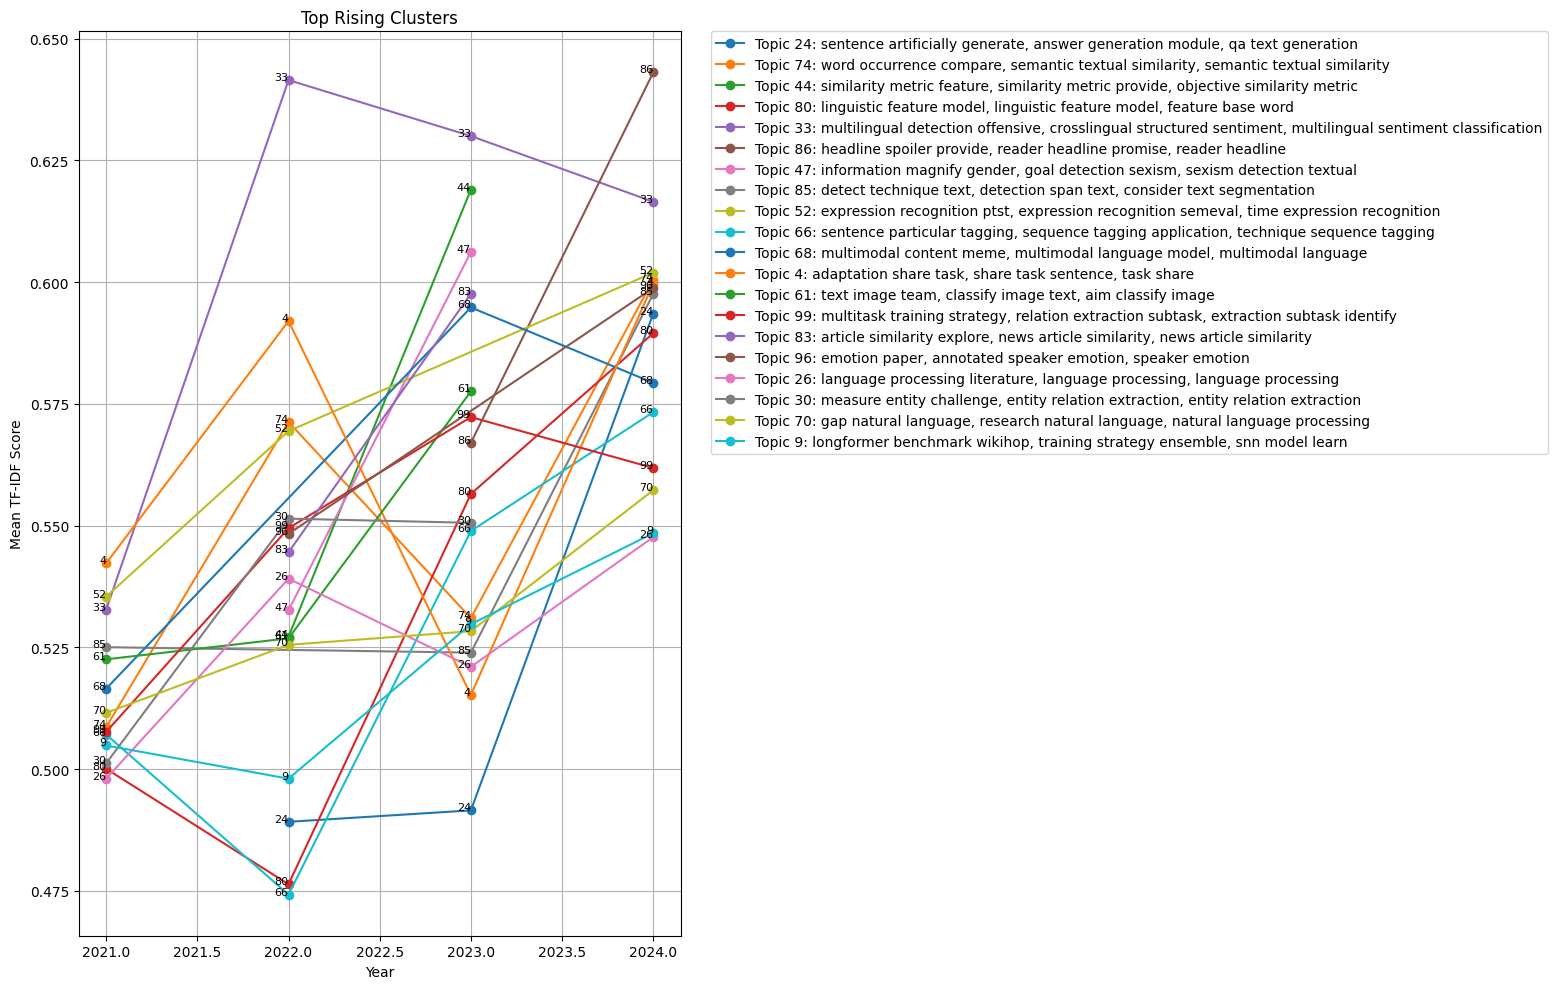

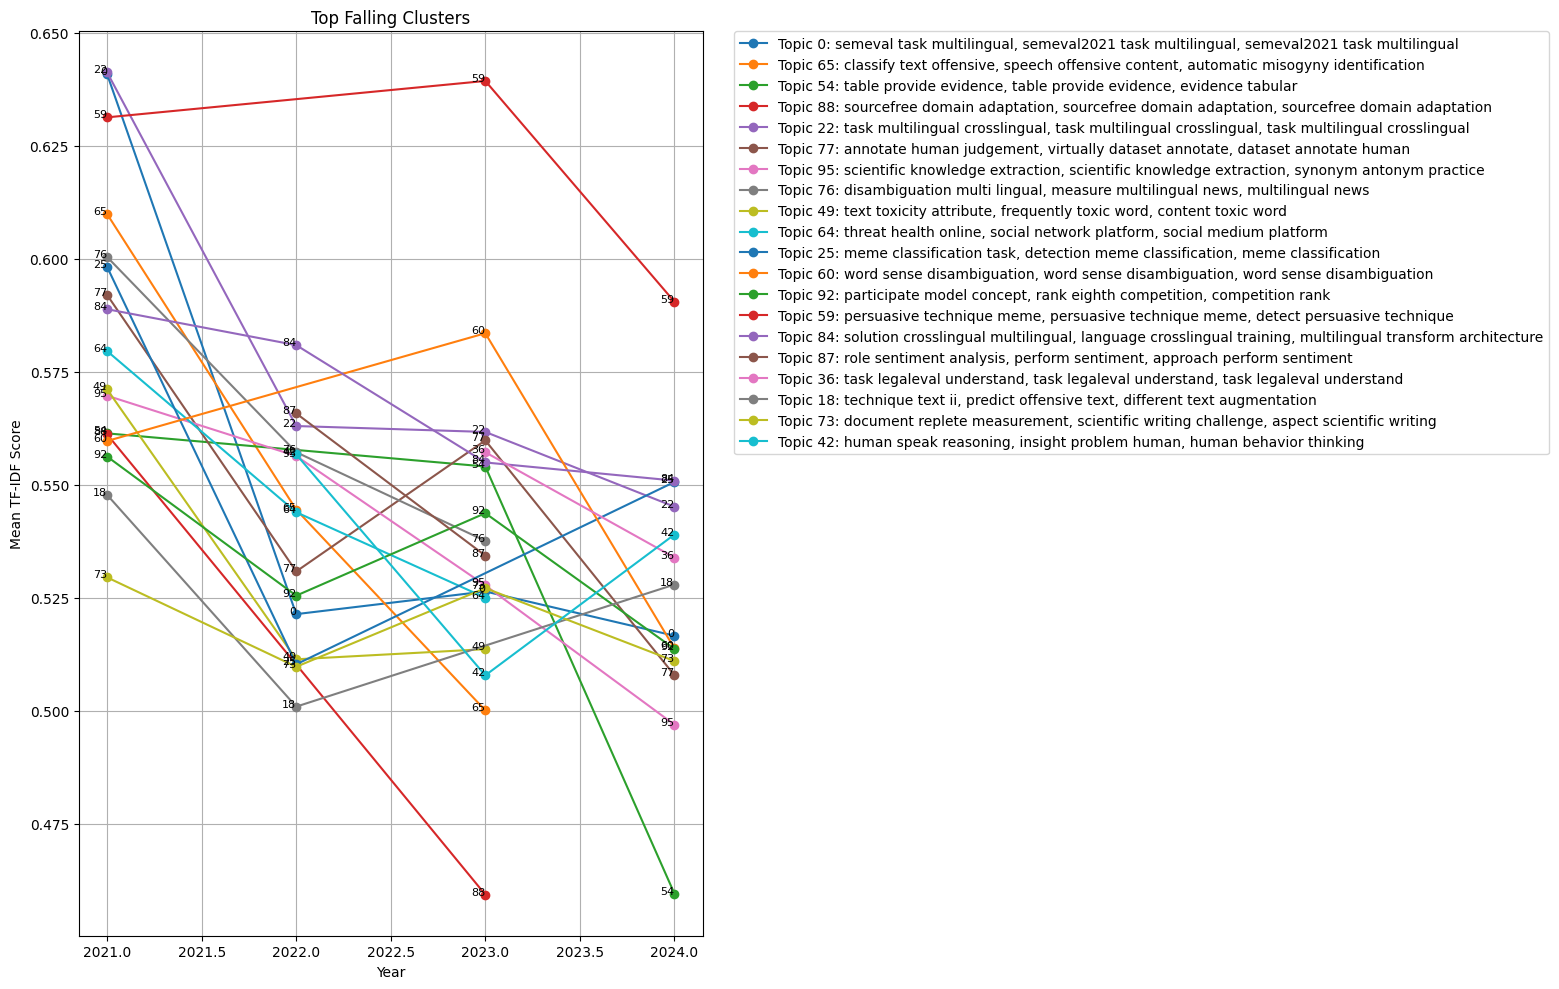

In [76]:
clustered_keyphrases = cluster_keyphrases(embeddings, all_keyphrase_list, n_clusters=100)
clustered_trends = analyze_clustered_trends(clustered_keyphrases, all_keyphrases)

# Identify risers and fallers
risers, fallers = identify_risers_and_fallers(clustered_trends, clustered_keyphrases)

# Plot top risers and fallers
plot_cluster_trends(risers, clustered_trends, "Top Rising Clusters")
plot_cluster_trends(fallers, clustered_trends, "Top Falling Clusters")

In [37]:
# Importing libraries required for next steps
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


#### **14. Building the Co-Occurrence Graph** 
This section constructs a graph where nodes are keyphrases, and edges indicate co-occurrence within the same abstract.


In [70]:
def build_cooccurrence_graph(keyphrases_by_abstract):
    """
    Build a co-occurrence graph from keyphrases in abstracts.
    """
    graph = nx.Graph()
    
    for abstract_keyphrases in keyphrases_by_abstract:
        for i, keyphrase1 in enumerate(abstract_keyphrases):
            for keyphrase2 in abstract_keyphrases[i + 1:]:
                if graph.has_edge(keyphrase1, keyphrase2):
                    graph[keyphrase1][keyphrase2]['weight'] += 1
                else:
                    graph.add_edge(keyphrase1, keyphrase2, weight=1)
    return graph

# Extract keyphrases for each abstract
keyphrases_by_abstract = []
for year, abstracts in abstracts_by_year.items():
    processed_abstracts = [preprocess_text(abstract) for abstract in abstracts]
    for abstract in processed_abstracts:
        keyphrases = [term for term, score in extract_keyphrases_keybert([abstract])]
        keyphrases_by_abstract.append(keyphrases)

# Build the co-occurrence graph
cooccurrence_graph = build_cooccurrence_graph(keyphrases_by_abstract)


#### **15. Trend Analysis of Keyphrase Relationships**
This section tracks how keyphrase relationships evolve across different years.

Year 2021: 776 nodes, 1793 edges
Top edges for 2021: [('task lexical complexity', 'lexical complexity prediction', {'weight': 8}), ('toxic span detection', 'task toxic span', {'weight': 8}), ('task multilingual crosslingual', 'task multilingual', {'weight': 6}), ('task lexical complexity', 'task lexical', {'weight': 5}), ('lexical complexity prediction', 'lexical complexity', {'weight': 5}), ('lexical complexity prediction', 'task lexical', {'weight': 4}), ('lexical complexity prediction', 'predict lexical complexity', {'weight': 4}), ('task lexical complexity', 'predict lexical complexity', {'weight': 3}), ('lexical complexity prediction', 'submit lexical complexity', {'weight': 3}), ('task multilingual crosslingual', 'semeval2021 task multilingual', {'weight': 3})]
Year 2022: 898 nodes, 2208 edges
Top edges for 2022: [('language pcl', 'condescend language pcl', {'weight': 10}), ('multimedia automatic misogyny', 'automatic misogyny identification', {'weight': 8}), ('multilingual idiom

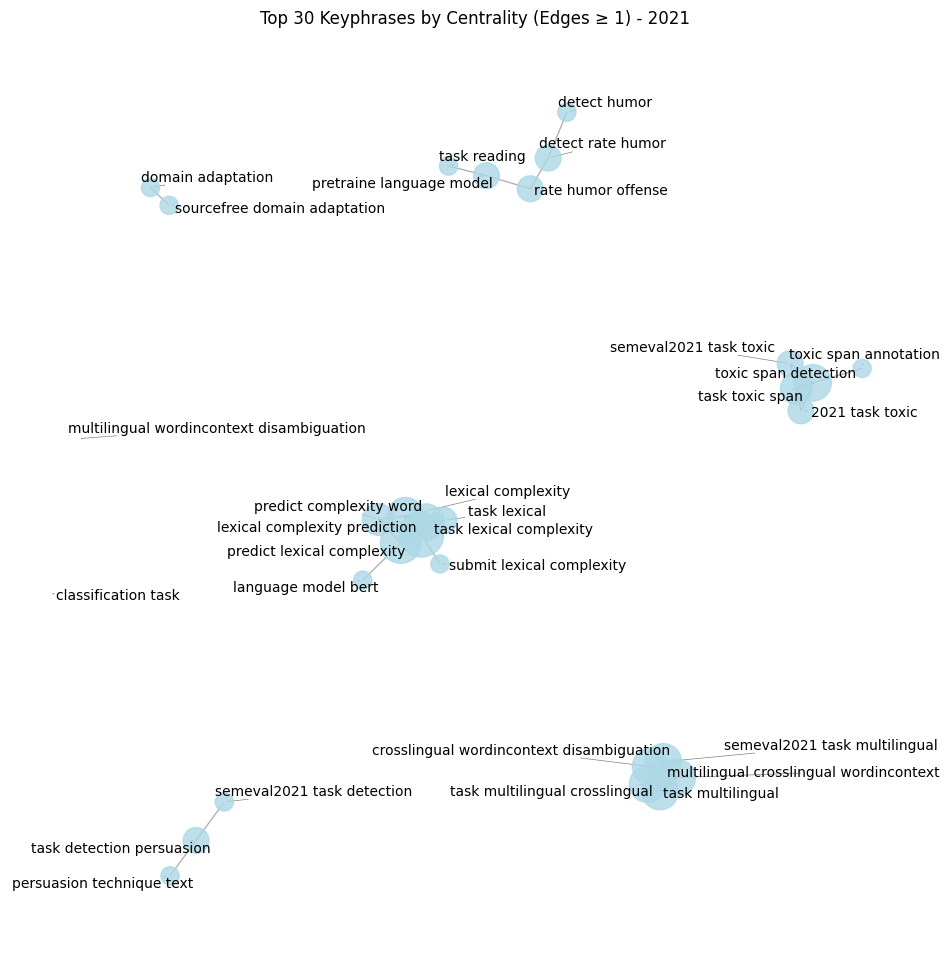

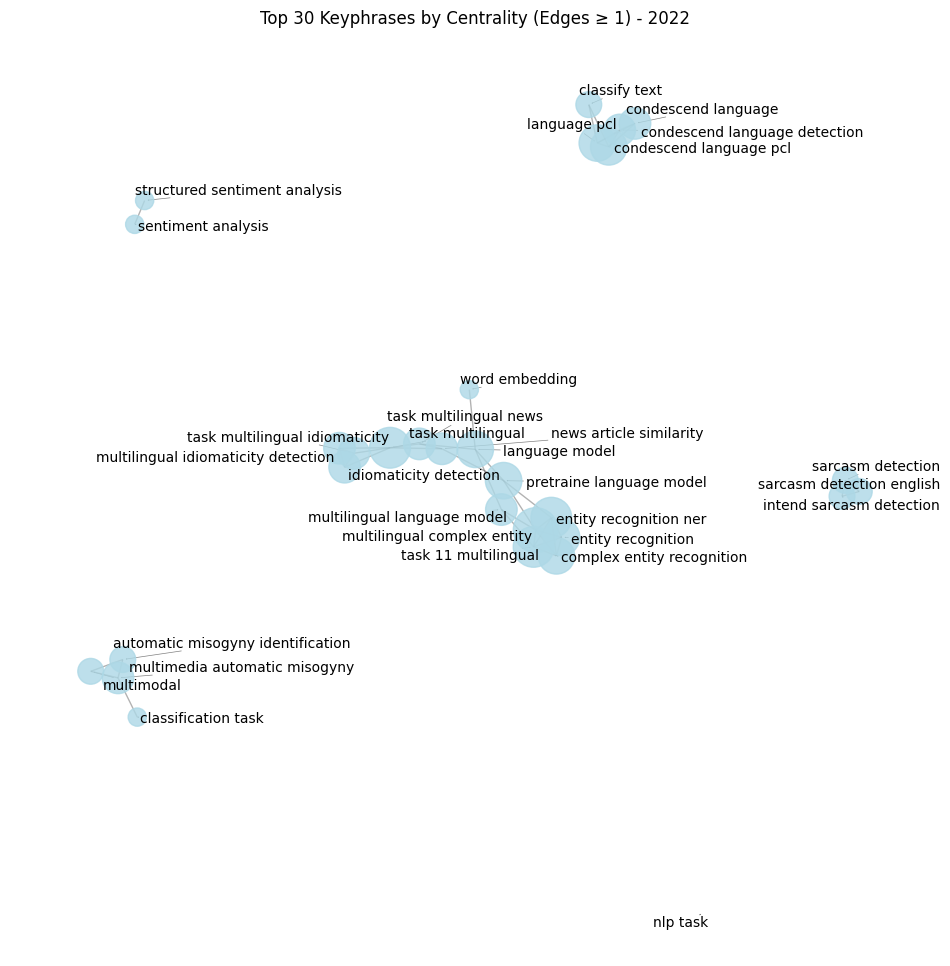

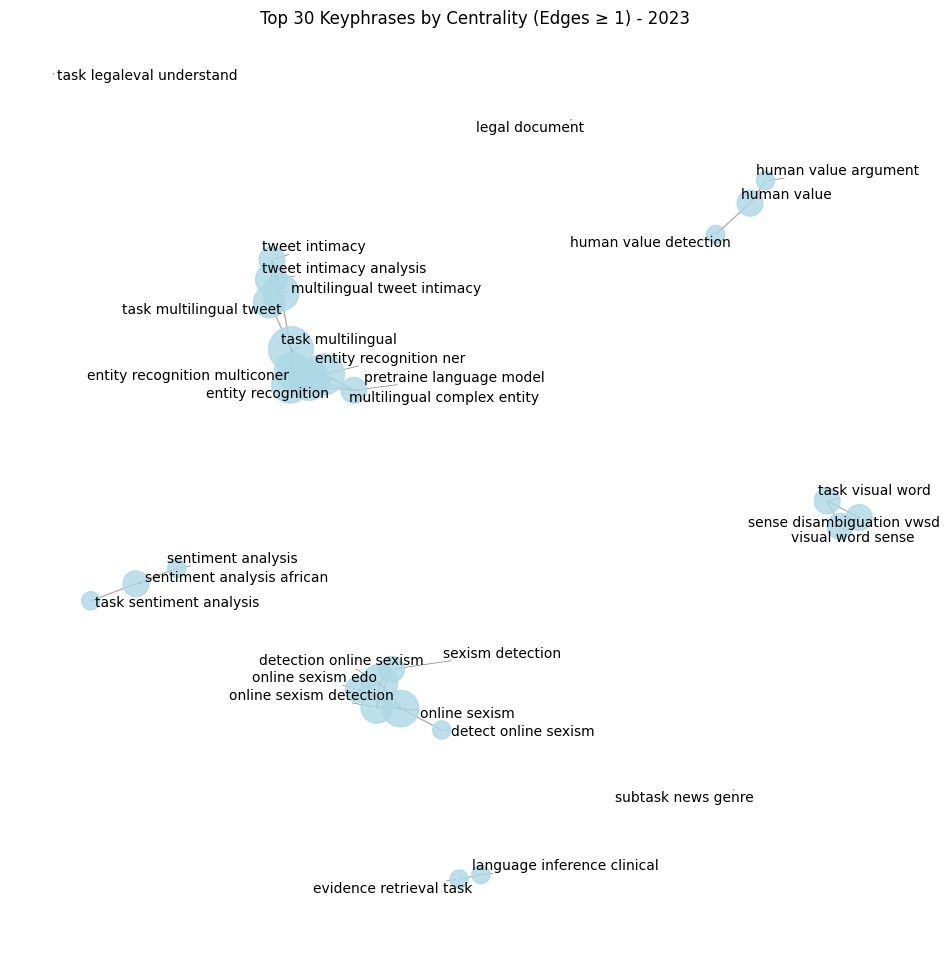

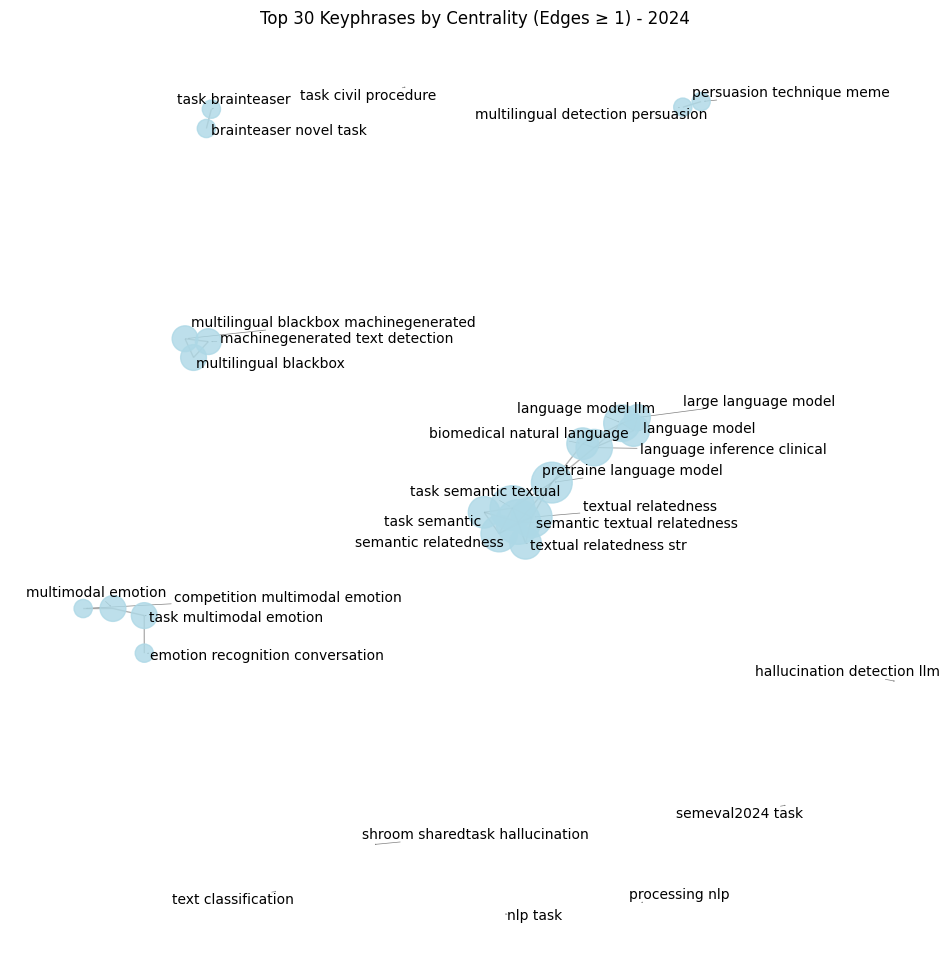

In [71]:
import matplotlib.pyplot as plt

def analyze_trends_by_year(abstracts_by_year, keyphrases_by_abstract):
    """
    Analyze the evolution of keyphrase relationships over time.
    Return a dictionary with yearly graphs and a summary of their properties.
    """
    yearly_graphs = {}
    year_summaries = {}

    # Keep track of how many abstracts per year we used
    # Note: This depends on how keyphrases_by_abstract was built. 
    # If it was built by iterating over all years sequentially, 
    # you need a way to know how many abstracts belong to each year.
    # For simplicity, assume keyphrases_by_abstract lines up exactly 
    # as we iterated before.
    
    # First, count how many abstracts per year
    abstracts_count_by_year = {y: len(abstracts) for y, abstracts in abstracts_by_year.items()}
    
    # Keep an index to slice keyphrases_by_abstract correctly
    start_idx = 0
    for year, abstracts in abstracts_by_year.items():
        end_idx = start_idx + abstracts_count_by_year[year]
        year_keyphrases = keyphrases_by_abstract[start_idx:end_idx]
        start_idx = end_idx
        
        # Build yearly graph
        graph = build_cooccurrence_graph(year_keyphrases)
        yearly_graphs[year] = graph
        
        # Gather summary statistics
        num_nodes = len(graph.nodes)
        num_edges = len(graph.edges)
        
        # Get top edges
        top_edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
        
        year_summaries[year] = {
            'num_nodes': num_nodes,
            'num_edges': num_edges,
            'top_edges': top_edges
        }
        
        # Print or log the summary
        print(f"Year {year}: {num_nodes} nodes, {num_edges} edges")
        print(f"Top edges for {year}: {top_edges}")
    
    return yearly_graphs, year_summaries

# Run the analysis
yearly_graphs, year_summaries = analyze_trends_by_year(abstracts_by_year, keyphrases_by_abstract)

def get_top_nodes_by_centrality(graph, top_n=50):
    """
    Get the top-n nodes by degree centrality.
    """
    degree_centrality = nx.degree_centrality(graph)
    # Sort nodes by centrality
    top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [node for node, centrality in top_nodes]

def filter_graph(graph, top_n=50, min_edge_weight=1):
    """
    Filter the graph to include only the top-n nodes by centrality and edges among them.
    Optionally, filter out edges below a certain weight.
    """
    top_nodes = get_top_nodes_by_centrality(graph, top_n=top_n)
    # Induce a subgraph with top nodes
    subgraph = graph.subgraph(top_nodes).copy()
    
    # Filter edges by weight if needed
    if min_edge_weight > 1:
        edges_to_remove = [(u, v) for u, v, d in subgraph.edges(data=True) if d['weight'] < min_edge_weight]
        subgraph.remove_edges_from(edges_to_remove)
    
    return subgraph

import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_filtered_graph(graph, title="Filtered Co-Occurrence Graph"):
    plt.figure(figsize=(12, 12))
    
    pos = nx.spring_layout(graph, seed=42)
    degree_centrality = nx.degree_centrality(graph)
    node_sizes = [5000 * degree_centrality[node] for node in graph.nodes()]
    
    # Draw edges
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color='lightblue', alpha=0.8)
    
    # Instead of using nx.draw_networkx_labels, we manually create text objects so we can adjust them
    texts = []
    for node, (x, y) in pos.items():
        texts.append(plt.text(x, y, node, fontsize=10, ha='center', va='center'))
    
    plt.title(title)
    plt.axis('off')
    
    # Adjust the positions of the labels to minimize overlap
    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
        only_move={'points':'y', 'texts':'xy'}  # For example, allow vertical movement for points and both for texts
    )
    
    plt.show()


def plot_yearly_filtered_graphs(yearly_graphs, top_n=50, min_edge_weight=1):
    """
    For each year, filter the graph and plot it.
    """
    for year, graph in sorted(yearly_graphs.items()):
        filtered_graph = filter_graph(graph, top_n=top_n, min_edge_weight=min_edge_weight)
        title = f"Top {top_n} Keyphrases by Centrality (Edges ≥ {min_edge_weight}) - {year}"
        plot_filtered_graph(filtered_graph, title=title)

# Example usage:
# Assuming you have yearly_graphs from the previous analysis:
# yearly_graphs, year_summaries = analyze_trends_by_year(abstracts_by_year, keyphrases_by_abstract)

plot_yearly_filtered_graphs(yearly_graphs, top_n=30, min_edge_weight=1)



Need pildid kujutavad valitud aastate kõige olulisemaid võtmefraase ning nende omavahelisi seoseid teadusartiklite kokkuvõtetes. Iga sõlm (punkt) graafikul tähistab üht märksõna ning jooned sõlmede vahel näitavad, millised märksõnad esinevad sageli koos. Mida tihedamalt ja tugevamalt märksõnad omavahel seotud on, seda tähtsamad ja kesksemad nad sellel ajaperioodil olid.

Graafiku abil saab ülevaate, millised teemad ja märksõnad mingil aastal rohkem esile tõusid ning millised jäid kõrvalisemaks või üksikuks. Kui mõni sõlm paistab graafikul üksi ilma ühendusteta, tähendab see, et valitud kriteeriumite (nt miinimumseose tugevus) tõttu ei leidu selle märksõna jaoks piisavalt tugevaid seoseid teiste märksõnadega.